# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets in Aleph Z->qqbar MC in various ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will try both tree based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

In the end, this exercise is the simple start on moving into the territory of multidimensional analasis.

### Data:
The input variables (X) are:
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis.
          The detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).
* prob_b: Probability of being a b-jet from the pointing of the tracks to the vertex.
* spheri: Sphericity of the event, i.e. how spherical it is.
* pt2rel: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* multip: Multiplicity of the jet (in a relative measure).
* bqvjet: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* ptlrel: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm (for reference).


### Task:
Thus, the task before you is to produce a function (ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.


* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   20th of April 2021

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [3]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    return N, fracWrong

# Main program start:

In [4]:
# Get data (with this very useful NumPy reader):
data = np.genfromtxt('AlephBtag_MC_small_v2.csv', names=True)

energy = data['energy']
cTheta = data['cTheta']
phi    = data['phi']
prob_b = data['prob_b']
spheri = data['spheri']
pt2rel = data['pt2rel']
multip = data['multip']
bqvjet = data['bqvjet']
ptlrel = data['ptlrel']
nnbjet = data['nnbjet']
isb    = data['isb']

### Produce 1D figures:
Define the histogram range and binning (important - MatPlotLib is NOT good at this):

In [5]:
Nbins = 100
xmin = 0.0
xmax = 1.0

### Make new lists selected based on what the jets really are (b-quark jet or light-quark jet):

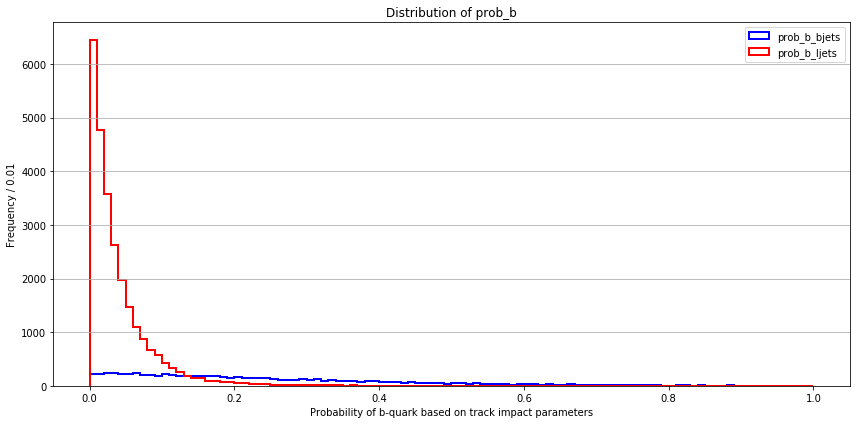

In [6]:
prob_b_bjets = []
prob_b_ljets = []
bqvjet_bjets = []
bqvjet_ljets = []
for i in np.arange(len(isb)) :
    if (isb[i] == 1) :
        prob_b_bjets.append(prob_b[i])
        bqvjet_bjets.append(bqvjet[i])
    else             :
        prob_b_ljets.append(prob_b[i])
        bqvjet_ljets.append(bqvjet[i])

# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')
fig.tight_layout()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

### Produce 2D figures:

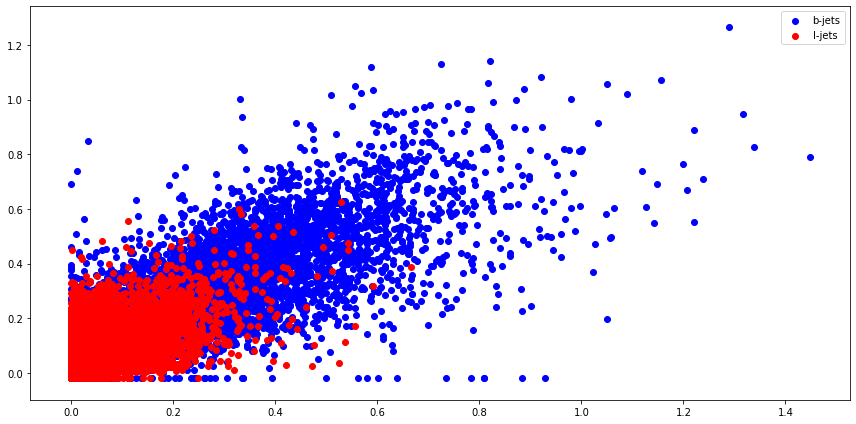

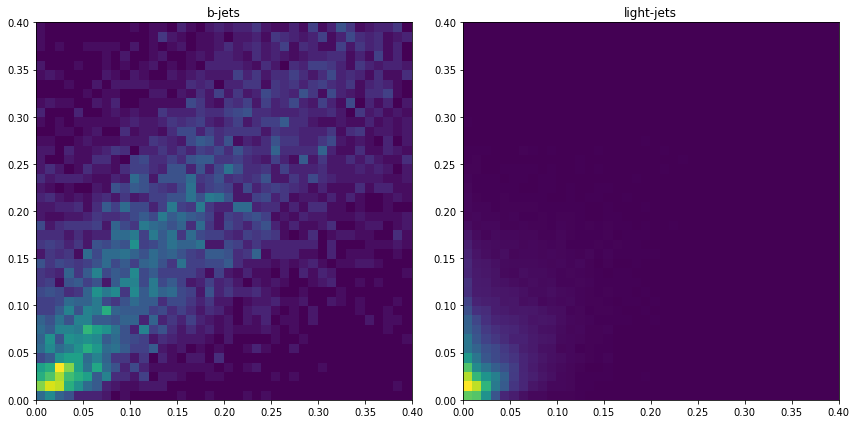

In [7]:
# First we try a scatter plot, to see how the individual events distribute themselves:
fig2, ax2 = plt.subplots(figsize=(12, 6))
scat2_prob_b_vs_bqvjet_bjets = ax2.scatter(prob_b_bjets, bqvjet_bjets, label='b-jets', color='blue')
scat2_prob_b_vs_bqvjet_ljets = ax2.scatter(prob_b_ljets, bqvjet_ljets, label='l-jets', color='red')
ax2.legend(loc='best')
fig2.tight_layout()

if SavePlots :
    fig2.savefig('Scatter_prob_b_vs_bqvjet.pdf', dpi=600)


# However, as can be seen in the figure, the overlap between b-jets and light-jets is large,
# and one covers much of the other in a scatter plot, which also does not show the amount of
# statistics in the dense regions. Therefore, we try two separate 2D histograms (zoomed):
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 6))
hist2_prob_b_vs_bqvjet_bjets = ax3[0].hist2d(prob_b_bjets, bqvjet_bjets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
hist2_prob_b_vs_bqvjet_ljets = ax3[1].hist2d(prob_b_ljets, bqvjet_ljets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
ax3[0].set_title("b-jets")
ax3[1].set_title("light-jets")
fig3.tight_layout()

if SavePlots :
    fig3.savefig('Hist2D_prob_b_vs_bqvjet.pdf', dpi=600)

# Selection:

In [8]:
"""
# I give the selection cuts names, so that they only need to be changed in ONE place (also ensures consistency!):
loose_propb = 0.10
tight_propb = 0.16
loose_bqvjet = 0.12
tight_bqvjet = 0.28

# If either of the variable clearly indicate b-quark, or of both loosely do so, call it a b-quark, otherwise not!
bquark=[]
for i in np.arange(len(prob_b)):
    if   (prob_b[i] > tight_propb)  :
        bquark.append(1)
    elif (bqvjet[i] > tight_bqvjet) :
        bquark.append(1)
    elif ((prob_b[i] > loose_propb) and (bqvjet[i] > loose_bqvjet)) :
        bquark.append(1)
    else :
        bquark.append(0)
"""     
        
# I give the selection cuts names, so that they only need to be changed in ONE place (also ensures consistency!):
loose_propb = 0.10
tight_propb = 0.16
loose_bqvjet = 0.12
tight_bqvjet = 0.28
loose_ptlrel = 0.40
tight_ptlrel = 0.60

bquark=[]
for i in np.arange(len(prob_b)):
    if   (prob_b[i] > tight_propb)  : bquark.append(1)
    elif (bqvjet[i] > tight_bqvjet) : bquark.append(1)
    elif (ptlrel[i] > tight_ptlrel) : bquark.append(1)
    elif ((prob_b[i] > loose_propb)  and (bqvjet[i] > loose_bqvjet)) : bquark.append(1)
    elif ((prob_b[i] > loose_propb)  and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
    elif ((bqvjet[i] > loose_bqvjet) and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
    elif ((ptlrel[i] > 0.3) and (prob_b[i] > 0.08) and (bqvjet[i] > 0.10)) : bquark.append(1)  # Adds very little!
    else : bquark.append(0)

### Evaluate the selection:

In [9]:
N, fracWrong = evaluate(bquark)
print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
print("  First number is my estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong = ( (0,1) + (1,0) ) / sum = ", fracWrong)


RESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:
  First number is my estimate, second is the MC truth:
  True-Negative (0,0)  =  24841
  False-Negative (0,1) =  2308
  False-Positive (1,0) =  1467
  True-Positive (1,1)  =  5352
    Fraction wrong = ( (0,1) + (1,0) ) / sum =  0.11113400847856807


### Compare with NN-approach from 1990'ies:

In [10]:
bquark=[]
for i in np.arange(len(prob_b)):
    if   (nnbjet[i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number is my estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong = ( (0,1) + (1,0) ) / sum = ", fracWrong)


ALEPH BJET TAG:
  First number is my estimate, second is the MC truth:
  True-Negative (0,0)  =  25464
  False-Negative (0,1) =  2519
  False-Positive (1,0) =  844
  True-Positive (1,1)  =  5141
    Fraction wrong = ( (0,1) + (1,0) ) / sum =  0.0990049458313707


### Brute force looping over selection values to get "optimal" selection:

In [11]:
# Here I make a range of values (min, max) from which I choose (randomly - more on that) from:
range_loose_prob_b = [0.08, 0.11]
range_tight_prob_b = [0.16, 0.21]
range_loose_bqvjet = [0.13, 0.18]
range_tight_bqvjet = [0.28, 0.40]
range_loose_ptlrel = [0.20, 0.40]
range_tight_ptlrel = [0.45, 0.65]

# Set high initially, and lowered by better selections:
fracWrong_min = 0.999

# Try several times (here 100):
for Ntest in range(100) :

    # Choose random selection and test it:
    loose_prob_b = r.uniform(range_loose_prob_b[0], range_loose_prob_b[1])
    tight_prob_b = r.uniform(range_tight_prob_b[0], range_tight_prob_b[1])
    loose_bqvjet = r.uniform(range_loose_bqvjet[0], range_loose_bqvjet[1])
    tight_bqvjet = r.uniform(range_tight_bqvjet[0], range_tight_bqvjet[1])
    loose_ptlrel = r.uniform(range_loose_ptlrel[0], range_loose_ptlrel[1])
    tight_ptlrel = r.uniform(range_tight_ptlrel[0], range_tight_ptlrel[1])

    bquark=[]
    for i in np.arange(len(prob_b)):
        if   (prob_b[i] > tight_prob_b) : bquark.append(1)
        elif (bqvjet[i] > tight_bqvjet) : bquark.append(1)
        elif (ptlrel[i] > tight_ptlrel) : bquark.append(1)
        elif ((prob_b[i] > loose_prob_b) and (bqvjet[i] > loose_bqvjet)) : bquark.append(1)
        elif ((prob_b[i] > loose_prob_b) and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
        elif ((bqvjet[i] > loose_bqvjet) and (ptlrel[i] > loose_ptlrel)) : bquark.append(1)
        else : bquark.append(0)

    N, fracWrong = evaluate(bquark)

    # Flag/print best selection(s):
    if (fracWrong < fracWrong_min) :
        print("\nRESULT OF TESTING MANY SELECTION CUTS:")
        print("  First number is my estimate, second is the MC truth:", Ntest)
        print("  True-Negative (0,0)  = ", N[0][0])
        print("  False-Negative (0,1) = ", N[0][1])
        print("  False-Positive (1,0) = ", N[1][0])
        print("  True-Positive (1,1)  = ", N[1][1])
        print("    Fraction wrong = ( (0,1) + (1,0) ) / sum = ", fracWrong)

        fracWrong_min = fracWrong
        print("  GOT A NEW MINIMUM.... GREAT!")
        print("  loose_prob_b = ", loose_prob_b)
        print("  tight_prob_b = ", tight_prob_b)
        print("  loose_bqvjet = ", loose_bqvjet)
        print("  tight_bqvjet = ", tight_bqvjet)
        print("  loose_ptlrel = ", loose_ptlrel)
        print("  tight_ptlrel = ", tight_ptlrel)



RESULT OF TESTING MANY SELECTION CUTS:
  First number is my estimate, second is the MC truth: 0
  True-Negative (0,0)  =  25269
  False-Negative (0,1) =  2568
  False-Positive (1,0) =  1039
  True-Positive (1,1)  =  5092
    Fraction wrong = ( (0,1) + (1,0) ) / sum =  0.10618817710786622
  GOT A NEW MINIMUM.... GREAT!
  loose_prob_b =  0.09123620356542088
  tight_prob_b =  0.2075357153204958
  loose_bqvjet =  0.16659969709057026
  tight_bqvjet =  0.35183901810364443
  loose_ptlrel =  0.23120372808848733
  tight_ptlrel =  0.48119890406724053

RESULT OF TESTING MANY SELECTION CUTS:
  First number is my estimate, second is the MC truth: 85
  True-Negative (0,0)  =  25281
  False-Negative (0,1) =  2578
  False-Positive (1,0) =  1027
  True-Positive (1,1)  =  5082
    Fraction wrong = ( (0,1) + (1,0) ) / sum =  0.10612929816297692
  GOT A NEW MINIMUM.... GREAT!
  loose_prob_b =  0.0984024558780737
  tight_prob_b =  0.18091215181453094
  loose_bqvjet =  0.17663642416770065
  tight_bqvjet = 